In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow.contrib.slim as slim
from tensorflow.contrib.seq2seq import BahdanauAttention
from tensorflow.contrib.seq2seq import AttentionMechanism
from tensorflow.contrib.seq2seq import AttentionWrapper
from tensorflow.contrib import seq2seq
from tensorflow import layers
from tensorflow.layers import dense
from tensorflow.nn.rnn_cell import LSTMCell
from tensorflow.nn.rnn_cell import DropoutWrapper
from tensorflow.nn.rnn_cell import ResidualWrapper
from tensorflow.nn.rnn_cell import MultiRNNCell
from tqdm import tqdm
from tensorflow import gfile
from tensorflow import logging
from tensorflow.python.ops.rnn_cell_impl import LSTMStateTuple
from tensorflow.contrib.seq2seq import AttentionWrapperState
import codecs

In [2]:
class WordSequence(object):
    def __init__(self,train_captions,max_len):
        self.dict = {'<pad>': 0, '<start>': 1, '<end>': 2,'<unknow>':3}
        self.corpus = train_captions
        self._word_count()
        self.max_len =max_len
        
        def _word_count(self):
            word_dict = {}
            for word in self.corpus:
                if word not in word_dict:
                    word_dict[word] = 0
                word_dict[word] = word_dict[word]+1
            print(len(word_dict))
            word_dict = {k:v for k,v in word_dict.items() if v>=2}
            print(len(word_dict))
            vocabulary = sorted(word_dict.items(), key=lambda x:-x[1])
            for i in vocabulary:
                self.dict[i[0]] = len(self.dict)
            self.id2word_dict = {value:key for key,value in self.dict.items()}
        
        
    def word2id(self,word_list):
        word_list.append('<end>')
        ids = []
        for word in word_list:
            if word in self.dict:
                ids.append(self.dict[word])
            else:
                ids.append(3)
        return ids
    
    def id2word(self,ids):
        words = []
        for i in ids:
            words.append(self.id2word_dict[i])
        return words

In [3]:
def vgg_19(inputs,
           num_classes=1000,
           is_training=True,
           dropout_keep_prob=0.5,
           spatial_squeeze=True,
           scope='vgg_19',
           fc_conv_padding='VALID',
           global_pool=False):
    with tf.variable_scope(scope, 'vgg_19', [inputs]) as sc:
        end_points_collection = sc.original_name_scope + '_end_points'
        # Collect outputs for conv2d, fully_connected and max_pool2d.
        with slim.arg_scope([slim.conv2d, slim.fully_connected, slim.max_pool2d],
                            outputs_collections=end_points_collection):
            net = slim.repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = slim.max_pool2d(net, [2, 2], scope='pool1')
            net = slim.repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = slim.max_pool2d(net, [2, 2], scope='pool2')
            net = slim.repeat(net, 4, slim.conv2d, 256, [3, 3], scope='conv3')
            net = slim.max_pool2d(net, [2, 2], scope='pool3')
            net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv4')
            net = slim.max_pool2d(net, [2, 2], scope='pool4')
            net = slim.repeat(net, 4, slim.conv2d, 512, [3, 3], scope='conv5')
            net = slim.max_pool2d(net, [2, 2], scope='pool5')

            # Use conv2d instead of fully_connected layers.
            net = slim.conv2d(net, 4096, [7, 7], padding=fc_conv_padding, scope='fc6')
            net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                             scope='dropout6')
            net = slim.conv2d(net, 4096, [1, 1], scope='fc7')
            # Convert end_points_collection into a end_point dict.
            end_points = slim.utils.convert_collection_to_dict(end_points_collection)
            if global_pool:
                net = tf.reduce_mean(net, [1, 2], keep_dims=True, name='global_pool')
                end_points['global_pool'] = net
            if num_classes:
                net = slim.dropout(net, dropout_keep_prob, is_training=is_training,
                               scope='dropout7')
            net = slim.conv2d(net, num_classes, [1, 1],
                              activation_fn=None,
                              normalizer_fn=None,
                              scope='fc8')
            if spatial_squeeze:
                net = tf.squeeze(net, [1, 2], name='fc8/squeezed')
            end_points[sc.name + '/fc8'] = net
        return net, end_points

In [4]:
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1, 1, 3))

In [5]:
def get_save_variables():
    variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='vgg_19')
    return variables

In [6]:
vgg_model = './vgg_model/vgg_19.ckpt'
img = tf.placeholder(shape=(None,224,224,3),dtype=tf.float32)
net,end_points = vgg_19(img-MEAN_VALUES)
img_features = end_points['vgg_19/conv5/conv5_3']
img_features = tf.reshape(img_features,shape=[-1,196,512])

In [7]:
saver = tf.train.Saver(get_save_variables())

In [8]:
def batch_norm(inputs, name,training=False):
    return tf.contrib.layers.batch_norm(inputs, decay=0.95, center=True, scale=True, is_training=training, 
                                        updates_collections=None, scope=name)

In [9]:
def build_single_cell(n_hidden,use_residual=True,keep_prob_placeholder=1):
        '''
        构建一个单独的rnn cell
        :param n_hidden: 隐藏层的神经单元数量
        :param use_residual: 是否使用residual wrapper
        :return:
        '''
        cell_type = LSTMCell
        cell = cell_type(n_hidden)
        #使用self.use_dropout 可以避免过拟合，等等。
        
        cell = DropoutWrapper(
            cell,
            dtype=tf.float32,
            output_keep_prob=keep_prob_placeholder,
            seed = 0 #一些层之间操作的随机数
            )
        #使用ResidualWrapper进行封装可以避免一些梯度消失或者梯度爆炸
        if use_residual:
            cell = ResidualWrapper(cell)
        return cell

In [10]:
def cell_input_fn(inputs,attention):
    
    
    '''
    根据attn_input_feeding属性来判断是否在attention计算前进行一次投影的计算
    使用注意力机制才会进行的运算
    :param inputs:
    :param attention:
    :return:
    '''

#     if not use_residual:
#         print(inputs.get_shape,'inputs_shape')
#         print(attention.get_shape,'inputs_shape')
#         print(tf.concat([inputs,attention],-1),'inputs和attention拼接之后的形状')
#         return tf.concat([inputs,attention],-1)

    attn_projection = layers.Dense(1024,
                                   dtype=tf.float32,
                                   use_bias=False,
                                   name='attention_cell_input_fn')

    '''
    这个attn_projection(array_ops.concat([inputs,attention],-1))我的理解就是
    layers.Dense(self.hidden_units,
                                   dtype=tf.float32,
                                   use_bias=False,
                                   name='attention_cell_input_fn')(array_ops.concat([inputs,attention],-1))
    Dense最终继承了Layer类，Layer中定义了call方法和__call__ 方法，Dense也重写了call方法，__call__方法中调用call方法，call方法中还是起一个全连接层层的作用，__call__
    方法中执行流程是：pre process，call，post process
    '''
    t1 = tf.concat([tf.cast(inputs,dtype=tf.float32),tf.cast(attention,dtype=tf.float32)],1)
    return tf.nn.relu(batch_norm(attn_projection(t1),'cell_input_fn',False))

In [11]:
target_vocab_size = 10656
hidden_size = 1024
batch_size = 1

In [12]:
e_initializer = tf.random_uniform_initializer(-1.0, 1.0)

In [13]:
with tf.variable_scope('captions') as decoder_scope:
    context = batch_norm(img_features,'context',False)
    context = tf.nn.relu(context)
    attention_mechanism = BahdanauAttention(
                num_units=512,
                memory=context,
                memory_sequence_length=[196]*batch_size
            )
    print(context,'context')
    
    cell = MultiRNNCell(
            [
                build_single_cell(hidden_size,use_residual=True,keep_prob_placeholder = 1) for _ in range(1)
            ])
    cell = AttentionWrapper(
            cell=cell,
            attention_mechanism=attention_mechanism,
            attention_layer_size=hidden_size,
            alignment_history=True,#这个是attention的历史信息
            cell_input_fn=cell_input_fn,#将attention拼接起来和input拼接起来
            name='Attention_Wrapper'
        )
    
    decoder_initial_state = cell.zero_state(
            batch_size,tf.float32
        )#这里初始化decoder_inital_state
    print(decoder_initial_state)

#     传递encoder的状态
    context_mean = tf.reduce_mean(context, 1)
    the_state = tf.nn.relu(batch_norm(dense(context_mean, hidden_size, name='initial_state'),'initial_state',False))
    the_memory = tf.nn.relu(batch_norm(dense(context_mean, hidden_size, name='initial_memory'),'initial_memory',False))
    the_cell_state_for_init = (LSTMStateTuple(the_memory,the_state),)
    print(the_cell_state_for_init)
    decoder_initial_state = decoder_initial_state.clone(
        cell_state = the_cell_state_for_init
    )
    
    #创建embedding向量
    words_embeddings = tf.get_variable(
                        name='embeddings',
                        shape=(target_vocab_size, 512),
                        initializer=e_initializer,
                        dtype=tf.float32
                    )
    
    decoder_output_projection = layers.Dense(
                target_vocab_size,
                dtype=tf.float32,
                use_bias=False,
                name='decoder_output_projection'
            )
    
    
    def embed_and_input_proj(inputs):
        '''
        这里根据inputs.name来判断是该返回图像的embed，还是word embed vector
        '''

        m = tf.nn.embedding_lookup(
            words_embeddings,
            inputs
        )
        
        return m
    start_tokens = tf.tile(
                [1],
                [batch_size]
            )
    decoding_helper = seq2seq.GreedyEmbeddingHelper(
        start_tokens=start_tokens,#这个是解码开始时，应该首先输入到解码器中去的，但在embed_and_input_proj函数需要替换成embed_img_input
        end_token=2,#这里vocab中的结束字符的编码为2
        embedding=embed_and_input_proj
    )
    
    inference_decoder  = seq2seq.BasicDecoder(
                cell=cell,
                helper=decoding_helper,
                initial_state=decoder_initial_state,
                output_layer=decoder_output_projection
            )
    
    (
            outputs,
            final_state,
            final_sequence_lengths
        ) = seq2seq.dynamic_decode(
            decoder=inference_decoder,
            output_time_major=False,
            impute_finished=False,
            maximum_iterations=20,
            swap_memory=True,
            scope=decoder_scope
    )
    
    alphas = final_state.alignment_history.concat()
    print(alphas)

Tensor("captions/Relu:0", shape=(?, 196, 512), dtype=float32) context
AttentionWrapperState(cell_state=(LSTMStateTuple(c=<tf.Tensor 'captions/AttentionWrapperZeroState/checked_cell_state:0' shape=(1, 1024) dtype=float32>, h=<tf.Tensor 'captions/AttentionWrapperZeroState/checked_cell_state_1:0' shape=(1, 1024) dtype=float32>),), attention=<tf.Tensor 'captions/AttentionWrapperZeroState/zeros_2:0' shape=(1, 1024) dtype=float32>, time=<tf.Tensor 'captions/AttentionWrapperZeroState/zeros_1:0' shape=() dtype=int32>, alignments=<tf.Tensor 'captions/AttentionWrapperZeroState/zeros:0' shape=(1, 196) dtype=float32>, alignment_history=<tensorflow.python.ops.tensor_array_ops.TensorArray object at 0x0000000018B11BE0>, attention_state=<tf.Tensor 'captions/AttentionWrapperZeroState/zeros_3:0' shape=(1, 196) dtype=float32>)
(LSTMStateTuple(c=<tf.Tensor 'captions/Relu_2:0' shape=(?, 1024) dtype=float32>, h=<tf.Tensor 'captions/Relu_1:0' shape=(?, 1024) dtype=float32>),)
Tensor("captions/TensorArrayConc

In [14]:
caption_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='captions')
caption_saver = tf.train.Saver(caption_params)

In [15]:
init = tf.global_variables_initializer()
local_init = tf.local_variables_initializer()

In [16]:
ws = None
with open('./ws.pkl','rb') as f:
    ws = pickle.load(f)
import cv2

In [19]:
captions = {}
with codecs.open ('./data/results_20130124.token','r','utf-8') as f:
    lines = f.readlines()
    bar = tqdm(lines)
    for line in bar:
        line = line.strip()
        words = line.split("\t")
        if words[0].split("#")[0] not in captions:
            captions[words[0].split("#")[0]]=[]
        else:
            caption = words[1]
            caption = caption.strip().lower()
            caption = caption.replace(',', '').replace("'", '').replace('"', '')
            caption = caption.replace('&', 'and').replace('(', '').replace(')', '').split()
            caption = [w for w in caption if len(w) > 0]
            captions[words[0].split("#")[0]].append(' '.join(caption))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158915/158915 [00:01<00:00, 147089.04it/s]


INFO:tensorflow:Restoring parameters from ./vgg_model/vgg_19.ckpt
INFO:tensorflow:Restoring parameters from ./mysave_model/captions.ckpt-31
(12, 196)
12


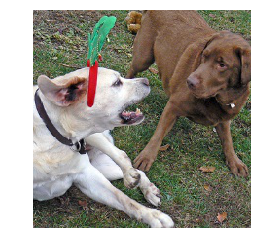

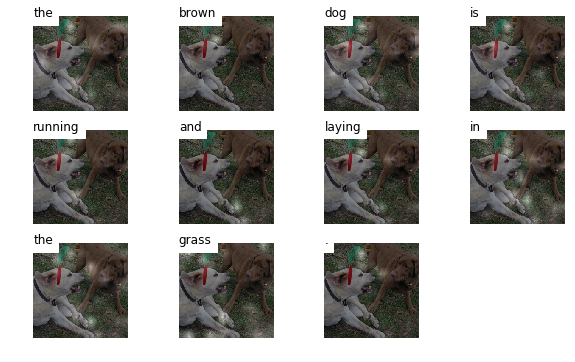

the white dog next to the brown dog is wearing a christmas headband .


In [20]:
predict_sentence = None
with tf.Session() as sess:
    saver.restore(save_path=vgg_model,sess=sess)
    caption_saver.restore(save_path='./mysave_model/captions.ckpt-31',sess=sess)
    mm = plt.imread('./data/crop_imgs/2071309418.jpg')
    feed_img = np.reshape(mm,newshape=(1,224,224,3))
    result = sess.run([outputs.sample_id,final_sequence_lengths,alphas],feed_dict={img:feed_img})
#     print(ws.id2word(result[0]))
    plt.imshow(mm)
#     plt.title(' '.join())
    plt.axis('off')
    print(result[2].shape)
    print(result[1][0])
    
    the_weights = result[2]
    
    predict_sentence = ws.id2word(result[0][0][:result[1][0]-1])
    
    mm = (mm - mm.min()) / (mm.max() - mm.min())
    n = int(np.ceil(np.sqrt(len(predict_sentence))))
    plt.figure(figsize=(10, 8))
    for i in range(len(predict_sentence)):
        word = predict_sentence[i]
        a = np.reshape(the_weights[i], (14, 14))
        a = cv2.resize(a, (224, 224))
        a = np.expand_dims(a, -1)
        a = (a - a.min()) / (a.max() - a.min())
        combine = 0.5 * mm +  0.5 * a
        plt.subplot(n, n, i + 1)
        plt.text(0, 1, word, color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(combine)
        plt.axis('off')
    plt.show()
    print(captions['2071309418.jpg'][1])


In [ ]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
import codecs

In [ ]:
captions['2071309418.jpg']

In [ ]:
predict_sentence = [' '.join(predict_sentence)]

In [ ]:
id2sentence = {}
gt = {}
gt['2071309418.jpg']=captions['2071309418.jpg']
id2sentence['2071309418.jpg'] = predict_sentence

scorers = [
    (Bleu(4), ['Bleu_1', 'Bleu_2', 'Bleu_3', 'Bleu_4']),
    (Rouge(), 'ROUGE_L'),
    (Cider(), 'CIDEr')
]

for scorer, name in scorers:
    score, _ = scorer.compute_score(gt, id2sentence)
    if type(score) == list:
        for n, s in zip(name, score):
            print(n, s)
    else:
        print(name, score)